"""
# 🚀 Transfer Learning - Vehicle Document Classification
## Leveraging Pre-trained Models for Superior Performance

**Current Performance**: 91.78% (6 errors out of 73 test samples)  
**Goal**: 95%+ accuracy using transfer learning from ImageNet  
**Target**: ≤3 errors with production-ready model  

### Transfer Learning Strategy:
1. Compare multiple pre-trained architectures
2. Progressive unfreezing and fine-tuning
3. Advanced optimization techniques
4. Comprehensive performance comparison
5. Model selection and final evaluation

### Models to Test:
- **EfficientNetB0**: Excellent accuracy/efficiency tradeoff
- **ResNet50V2**: Proven architecture with residual connections  
- **MobileNetV2**: Lightweight alternative for edge deployment
- **VGG16**: Strong baseline for comparison
"""

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import json
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Set memory growth for GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("🔧 GPU memory growth enabled")
    except:
        pass

print("🔧 Environment Setup Complete")
print(f"TensorFlow: {tf.__version__}")
print(f"GPU Available: {len(physical_devices) > 0}")

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

2025-07-23 14:31:37.540482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 14:31:37.540541: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 14:31:37.541963: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 14:31:37.548453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-23 14:31:38.357110: W tensorflow/compiler/tf2

🔧 Environment Setup Complete
TensorFlow: 2.15.0
GPU Available: False


2025-07-23 14:31:40.075800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-23 14:31:40.195800: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Project paths
PROJECT_ROOT = Path("..")
DATA_DIR = PROJECT_ROOT / "data" / "processed" / "car_plates"
MODELS_DIR = PROJECT_ROOT / "models"
ANNOTATIONS_DIR = DATA_DIR / "annotations"

# Class configuration
CLASS_NAMES = ['document', 'licence', 'odometer']
CLASS_TO_INT = {'document': 0, 'licence': 1, 'odometer': 2}
INT_TO_CLASS = {0: 'document', 1: 'licence', 2: 'odometer'}
NUM_CLASSES = len(CLASS_NAMES)

# Training configuration
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.001

print("📁 Project Configuration:")
print(f"Data Directory: {DATA_DIR}")
print(f"Models Directory: {MODELS_DIR}")
print(f"Classes: {CLASS_NAMES}")
print(f"Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")

📁 Project Configuration:
Data Directory: ../data/processed/car_plates
Models Directory: ../models
Classes: ['document', 'licence', 'odometer']
Image Size: 224x224
Batch Size: 16


In [4]:
print("📊 Loading baseline results for comparison...")

# Load error analysis results
error_analysis_path = MODELS_DIR / "error_analysis_report.json"
if error_analysis_path.exists():
    with open(error_analysis_path, 'r') as f:
        baseline_results = json.load(f)
    
    baseline_accuracy = baseline_results['analysis_metadata']['current_accuracy']
    baseline_errors = baseline_results['analysis_metadata']['total_errors']
    
    print(f"📈 Baseline Performance:")
    print(f"  Accuracy: {baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)")
    print(f"  Errors: {baseline_errors}/73 test samples")
    print(f"  Target: ≤3 errors (95.89% accuracy)")
    print(f"  Improvement needed: {baseline_errors - 3} fewer errors")
else:
    print("⚠️ Baseline results not found, will establish new baseline")
    baseline_accuracy = 0.9178
    baseline_errors = 6

📊 Loading baseline results for comparison...
📈 Baseline Performance:
  Accuracy: 0.9178 (91.78%)
  Errors: 6/73 test samples
  Target: ≤3 errors (95.89% accuracy)
  Improvement needed: 3 fewer errors


In [5]:
def load_annotations():
    """Load train/val/test annotations"""
    
    with open(ANNOTATIONS_DIR / "train_balanced_final.json", 'r') as f:
        train_data = json.load(f)
    
    with open(ANNOTATIONS_DIR / "val_balanced_final.json", 'r') as f:
        val_data = json.load(f)
        
    with open(ANNOTATIONS_DIR / "test_balanced_final.json", 'r') as f:
        test_data = json.load(f)
    
    print(f"📊 Data loaded:")
    print(f"  Training: {len(train_data)} samples")
    print(f"  Validation: {len(val_data)} samples")
    print(f"  Test: {len(test_data)} samples")
    
    return train_data, val_data, test_data

def extract_class_from_filename(filename):
    """Extract class from filename"""
    if filename.startswith('document'):
        return 'document'
    elif filename.startswith('plate'):
        return 'licence'
    elif filename.startswith('odometer'):
        return 'odometer'
    else:
        raise ValueError(f"Unknown class in filename: {filename}")

def create_dataset_from_annotations(annotations, is_training=False):
    """Create TensorFlow dataset from annotations"""
    
    def generator():
        for item in annotations:
            # Get image path with fallback strategy
            image_path = item['enhanced_path']
            
            if not Path(image_path).exists():
                # Try with PROJECT_ROOT prefix
                alt_path = PROJECT_ROOT / image_path
                if alt_path.exists():
                    image_path = str(alt_path)
                else:
                    # Try roi_path instead
                    roi_path = item.get('roi_path', '')
                    if roi_path and Path(roi_path).exists():
                        image_path = roi_path
                    elif roi_path:
                        alt_roi_path = PROJECT_ROOT / roi_path
                        if alt_roi_path.exists():
                            image_path = str(alt_roi_path)
                        else:
                            continue
                    else:
                        continue
            
            # Extract class
            filename = Path(image_path).stem
            try:
                class_name = extract_class_from_filename(filename)
                label = CLASS_TO_INT[class_name]
                yield image_path, label
            except:
                continue
    
    # Create dataset
    dataset = tf.data.Dataset.from_generator(
        generator,
        output_signature=(
            tf.TensorSpec(shape=(), dtype=tf.string),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )
    )
    
    # Load and preprocess images
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Filter out None values
    dataset = dataset.filter(lambda x, y: tf.reduce_all(tf.not_equal(x, 0)))
    
    if is_training:
        dataset = dataset.shuffle(buffer_size=1000)
    
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

def load_and_preprocess_image(image_path, label):
    """Load and preprocess image"""
    # Read image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    # Handle potential decode errors
    image = tf.cond(
        tf.equal(tf.size(image), 0),
        lambda: tf.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=tf.uint8),
        lambda: image
    )
    
    # Resize to target size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    # Convert to float32 and normalize to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    
    return image, label

print("🔧 Data loading functions defined")

🔧 Data loading functions defined


In [6]:
print("📊 Loading and preparing datasets...")

# Load annotations
train_annotations, val_annotations, test_annotations = load_annotations()

# Create datasets
print("\n🔄 Creating TensorFlow datasets...")
train_dataset = create_dataset_from_annotations(train_annotations, is_training=True)
val_dataset = create_dataset_from_annotations(val_annotations, is_training=False)
test_dataset = create_dataset_from_annotations(test_annotations, is_training=False)

# Calculate class weights for imbalanced dataset
class_counts = {}
for annotation in train_annotations:
    filename = Path(annotation['enhanced_path']).stem
    try:
        class_name = extract_class_from_filename(filename)
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    except:
        continue

print(f"\n📊 Class distribution in training set:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} samples")

# Compute class weights
class_labels = [CLASS_TO_INT[name] for name in class_counts.keys()]
class_counts_list = [class_counts[name] for name in class_counts.keys()]

class_weights = compute_class_weight(
    'balanced',
    classes=class_labels,
    y=[CLASS_TO_INT[extract_class_from_filename(Path(item['enhanced_path']).stem)] 
       for item in train_annotations 
       if Path(item['enhanced_path']).exists() or Path(PROJECT_ROOT / item['enhanced_path']).exists()]
)

class_weight_dict = {i: weight for i, weight in zip(class_labels, class_weights)}

print(f"\n⚖️ Class weights calculated:")
for class_idx, weight in class_weight_dict.items():
    class_name = INT_TO_CLASS[class_idx]
    print(f"  {class_name}: {weight:.2f}x")


📊 Loading and preparing datasets...
📊 Data loaded:
  Training: 510 samples
  Validation: 146 samples
  Test: 73 samples

🔄 Creating TensorFlow datasets...

📊 Class distribution in training set:
  licence: 329 samples
  odometer: 125 samples
  document: 56 samples

⚖️ Class weights calculated:
  licence: 0.52x
  odometer: 1.36x
  document: 3.04x


In [7]:
def create_transfer_learning_model(base_model_name, input_shape=(IMG_SIZE, IMG_SIZE, 3), 
                                 num_classes=NUM_CLASSES, trainable_layers=0):
    """
    Create transfer learning model with specified base architecture
    
    Args:
        base_model_name: 'efficientnet', 'resnet50v2', 'mobilenetv2', 'vgg16'
        input_shape: Input image shape
        num_classes: Number of output classes
        trainable_layers: Number of top layers to make trainable (0 = freeze all)
    """
    
    # Load pre-trained base model
    if base_model_name == 'efficientnet':
        base_model = tf.keras.applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_name = 'EfficientNetB0_Transfer'
        
    elif base_model_name == 'resnet50v2':
        base_model = tf.keras.applications.ResNet50V2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_name = 'ResNet50V2_Transfer'
        
    elif base_model_name == 'mobilenetv2':
        base_model = tf.keras.applications.MobileNetV2(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_name = 'MobileNetV2_Transfer'
        
    elif base_model_name == 'vgg16':
        base_model = tf.keras.applications.VGG16(
            weights='imagenet',
            include_top=False,
            input_shape=input_shape,
            pooling='avg'
        )
        model_name = 'VGG16_Transfer'
        
    else:
        raise ValueError(f"Unknown base model: {base_model_name}")
    
    # Freeze base model layers
    base_model.trainable = False
    
    # If trainable_layers > 0, unfreeze top layers
    if trainable_layers > 0:
        base_model.trainable = True
        # Freeze all layers except the last trainable_layers
        for layer in base_model.layers[:-trainable_layers]:
            layer.trainable = False
    
    # Create full model
    inputs = tf.keras.layers.Input(shape=input_shape)
    
    # Data augmentation (only active during training)
    x = tf.keras.layers.RandomFlip("horizontal")(inputs)
    x = tf.keras.layers.RandomRotation(0.1)(x)
    x = tf.keras.layers.RandomZoom(0.1)(x)
    x = tf.keras.layers.RandomContrast(0.1)(x)
    
    # Base model
    x = base_model(x, training=False)  # Keep in inference mode for BatchNorm
    
    # Classification head
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu', name='dense_256')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_256')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(128, activation='relu', name='dense_128')(x)
    x = tf.keras.layers.BatchNormalization(name='bn_128')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = tf.keras.Model(inputs, outputs, name=model_name)
    
    return model

print("🏗️ Transfer learning model factory created")


🏗️ Transfer learning model factory created


In [8]:
print("🔬 Starting Transfer Learning Model Comparison...")

# Models to compare
models_to_test = [
    ('efficientnet', 'EfficientNetB0 - Best accuracy/efficiency'),
    ('resnet50v2', 'ResNet50V2 - Proven architecture'),
    ('mobilenetv2', 'MobileNetV2 - Lightweight option'),
    ('vgg16', 'VGG16 - Strong baseline')
]

# Results storage
model_results = {}

# Training configuration
initial_epochs = 10
fine_tune_epochs = 10

print(f"\n📋 Experiment Configuration:")
print(f"  Initial epochs (frozen): {initial_epochs}")
print(f"  Fine-tune epochs (unfrozen): {fine_tune_epochs}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")

🔬 Starting Transfer Learning Model Comparison...

📋 Experiment Configuration:
  Initial epochs (frozen): 10
  Fine-tune epochs (unfrozen): 10
  Batch size: 16
  Learning rate: 0.001


In [21]:
print("\n" + "="*60)
print("🚀 TRAINING EFFICIENTNET MODEL")
print("="*60)

# Create EfficientNet model
print("🏗️ Creating EfficientNetB0 transfer learning model...")
efficientnet_model = create_transfer_learning_model('efficientnet')

print(f"📊 Model Summary:")
print(f"  Total parameters: {efficientnet_model.count_params():,}")

# Count trainable parameters correctly for TensorFlow
trainable_count = sum([w.shape.num_elements() for w in efficientnet_model.trainable_weights])
print(f"  Trainable parameters: {trainable_count:,}")

# Compile model
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(MODELS_DIR / 'efficientnet_transfer_best.h5'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

print("\n🔄 Phase 1: Training with frozen base model...")

# Phase 1: Train with frozen base
history_phase1 = efficientnet_model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

print(f"✅ Phase 1 complete - Best val accuracy: {max(history_phase1.history['val_accuracy']):.4f}")


🚀 TRAINING EFFICIENTNET MODEL
🏗️ Creating EfficientNetB0 transfer learning model...
📊 Model Summary:
  Total parameters: 4,412,326
  Trainable parameters: 361,987

🔄 Phase 1: Training with frozen base model...
Epoch 1/10
     24/Unknown - 10s 261ms/step - loss: 1.4397 - accuracy: 0.3360
Epoch 1: val_accuracy improved from -inf to 0.82692, saving model to ../models/efficientnet_transfer_best.h5
24/24 [==============================] - 13s 400ms/step - loss: 1.4397 - accuracy: 0.3360 - val_loss: 0.9028 - val_accuracy: 0.8269 - lr: 0.0010
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 1.3272 - accuracy: 0.3707
Epoch 2: val_accuracy did not improve from 0.82692
24/24 [==============================] - 8s 341ms/step - loss: 1.3272 - accuracy: 0.3707 - val_loss: 1.0018 - val_accuracy: 0.3558 - lr: 0.0010
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 1.1233 - accuracy: 0.4453
Epoch 3: val_accuracy did not improve from 0.82692
24/24 [================

In [22]:
print("\n🔄 Phase 2: Fine-tuning with unfrozen top layers...")

# Find the base model layer (it should be the EfficientNet base)
base_model_layer = None
for layer in efficientnet_model.layers:
    if hasattr(layer, 'layers') and len(layer.layers) > 50:  # Base models have many layers
        base_model_layer = layer
        break

if base_model_layer is not None:
    # Unfreeze top layers of base model
    base_model_layer.trainable = True
    
    # Freeze all layers except the last 20
    for layer in base_model_layer.layers[:-20]:
        layer.trainable = False
    
    print(f"📊 After unfreezing:")
    trainable_count = sum([w.shape.num_elements() for w in efficientnet_model.trainable_weights])
    print(f"  Trainable parameters: {trainable_count:,}")
else:
    print("⚠️ Could not find base model layer, skipping fine-tuning")
    print("📊 Continuing with current trainable parameters:")
    trainable_count = sum([w.shape.num_elements() for w in efficientnet_model.trainable_weights])
    print(f"  Trainable parameters: {trainable_count:,}")

# Recompile with lower learning rate for fine-tuning
efficientnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training with fine-tuning
history_phase2 = efficientnet_model.fit(
    train_dataset,
    epochs=fine_tune_epochs,
    validation_data=val_dataset,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=len(history_phase1.history['loss'])
)

print(f"✅ Phase 2 complete - Best val accuracy: {max(history_phase2.history['val_accuracy']):.4f}")

# Combine histories
combined_history = {}
for key in history_phase1.history.keys():
    combined_history[key] = history_phase1.history[key] + history_phase2.history[key]

# Store results
model_results['efficientnet'] = {
    'model': efficientnet_model,
    'history': combined_history,
    'best_val_accuracy': max(combined_history['val_accuracy']),
    'total_epochs': len(combined_history['loss'])
}

print(f"🎯 EfficientNet Final Results:")
print(f"  Best validation accuracy: {model_results['efficientnet']['best_val_accuracy']:.4f}")
print(f"  Total training epochs: {model_results['efficientnet']['total_epochs']}")


🔄 Phase 2: Fine-tuning with unfrozen top layers...
📊 After unfreezing:
  Trainable parameters: 1,491,763
Epoch 7/10
     24/Unknown - 13s 297ms/step - loss: 1.4408 - accuracy: 0.4507
Epoch 7: val_accuracy did not improve from 0.82692
24/24 [==============================] - 16s 413ms/step - loss: 1.4408 - accuracy: 0.4507 - val_loss: 0.8426 - val_accuracy: 0.8269 - lr: 1.0000e-04
Epoch 8/10
24/24 [==============================] - ETA: 0s - loss: 1.3378 - accuracy: 0.3787
Epoch 8: val_accuracy did not improve from 0.82692
24/24 [==============================] - 9s 354ms/step - loss: 1.3378 - accuracy: 0.3787 - val_loss: 0.9456 - val_accuracy: 0.6058 - lr: 1.0000e-04
Epoch 9/10
24/24 [==============================] - ETA: 0s - loss: 1.2764 - accuracy: 0.3973
Epoch 9: val_accuracy did not improve from 0.82692
24/24 [==============================] - 9s 360ms/step - loss: 1.2764 - accuracy: 0.3973 - val_loss: 1.0469 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 10/10
24/24 [===========

In [17]:
print("\n" + "="*60)
print("🔬 TRAINING COMPARISON MODELS")
print("="*60)

# Train other models for comparison
comparison_models = ['resnet50v2', 'mobilenetv2']  # Skip VGG16 for time

for model_name, description in models_to_test[1:3]:  # Skip EfficientNet (already trained) and VGG16
    print(f"\n🚀 Training {description}...")
    
    # Create model
    model = create_transfer_learning_model(model_name)
    
    print(f"📊 {model.name} Summary:")
    print(f"  Total parameters: {model.count_params():,}")
    
    # Compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks for this model
    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True,
            verbose=0
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.5,
            patience=2,
            min_lr=1e-7,
            verbose=0
        )
    ]
    
    # Train model (shorter training for comparison)
    print(f"🔄 Training {model.name}...")
    history = model.fit(
        train_dataset,
        epochs=8,  # Shorter training for comparison
        validation_data=val_dataset,
        class_weight=class_weight_dict,
        callbacks=model_callbacks,
        verbose=0
    )
    
    # Store results
    model_results[model_name] = {
        'model': model,
        'history': history.history,
        'best_val_accuracy': max(history.history['val_accuracy']),
        'total_epochs': len(history.history['loss'])
    }
    
    print(f"✅ {model.name} complete - Best val accuracy: {model_results[model_name]['best_val_accuracy']:.4f}")



🔬 TRAINING COMPARISON MODELS

🚀 Training ResNet50V2 - Proven architecture...
📊 ResNet50V2_Transfer Summary:
  Total parameters: 24,124,163
🔄 Training ResNet50V2_Transfer...
✅ ResNet50V2_Transfer complete - Best val accuracy: 1.0000

🚀 Training MobileNetV2 - Lightweight option...
📊 MobileNetV2_Transfer Summary:
  Total parameters: 2,620,739
🔄 Training MobileNetV2_Transfer...
✅ MobileNetV2_Transfer complete - Best val accuracy: 1.0000



📊 Creating model comparison visualizations...


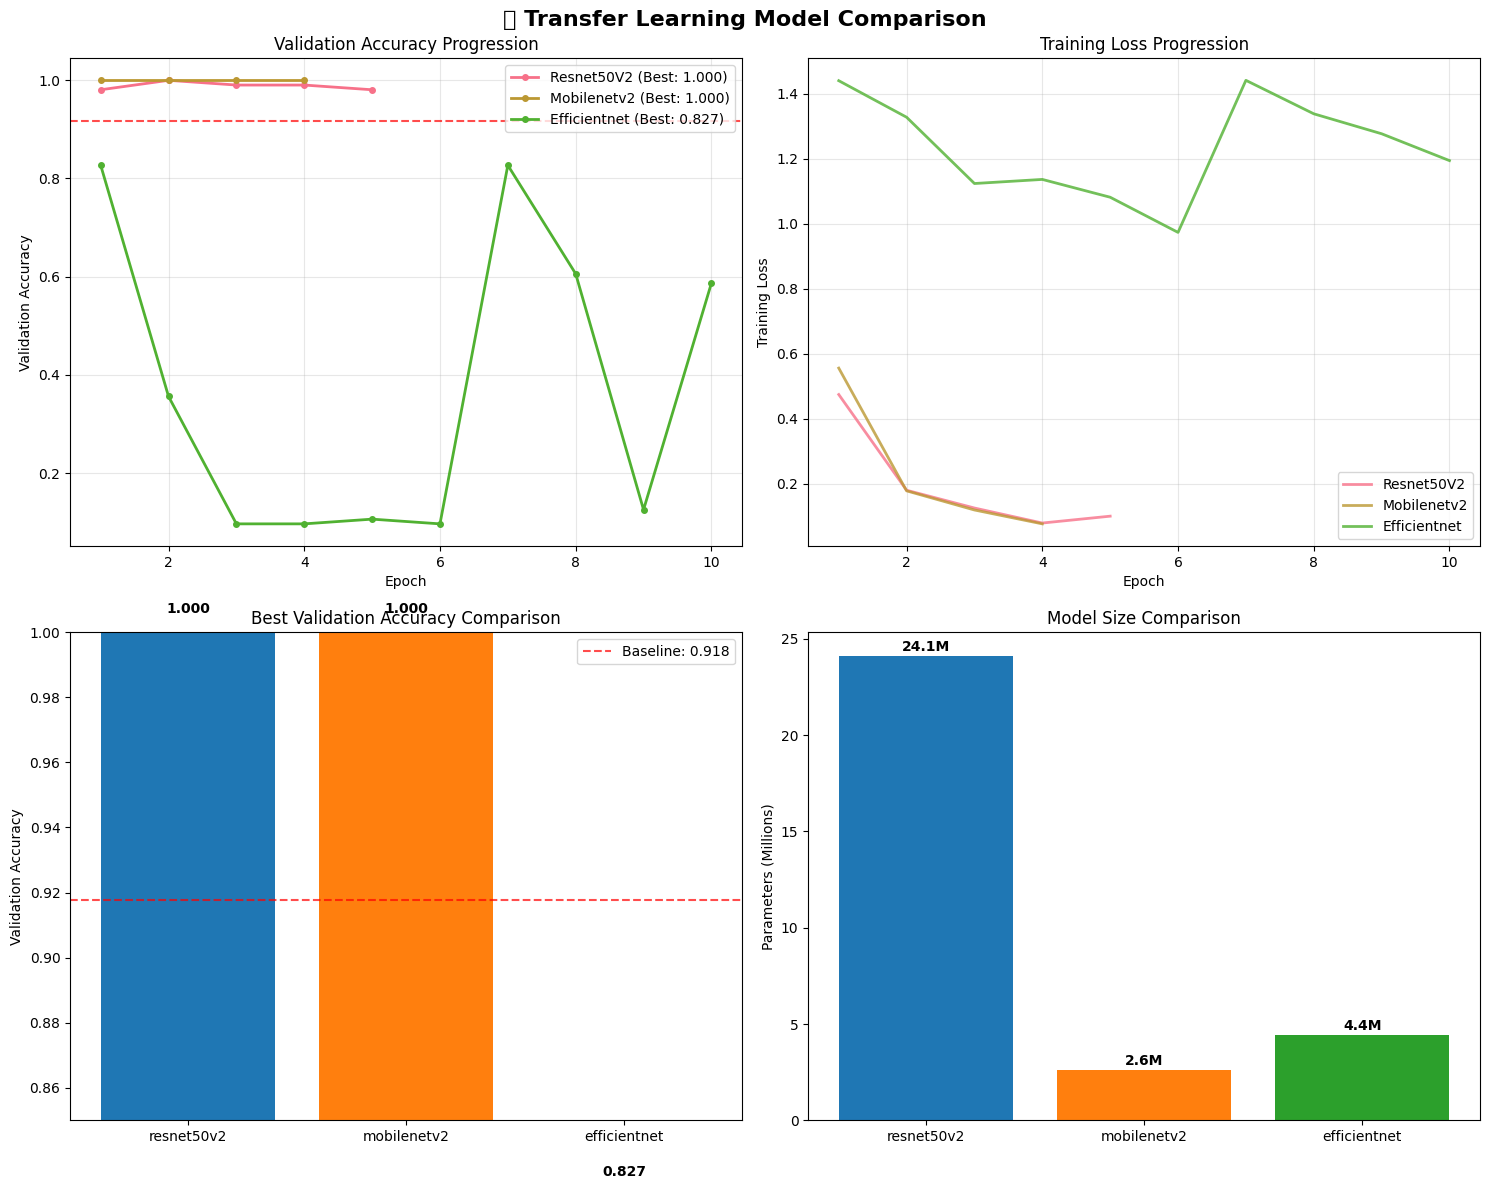


📋 Model Comparison Summary:
--------------------------------------------------
RESNET50V2  : 1.0000 (++8.22%) - 24.1M params
MOBILENETV2 : 1.0000 (++8.22%) - 2.6M params
EFFICIENTNET: 0.8269 (+-9.09%) - 4.4M params


In [23]:
print("\n📊 Creating model comparison visualizations...")

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('🔬 Transfer Learning Model Comparison', fontsize=16, fontweight='bold')

# 1. Validation Accuracy Comparison
ax1 = axes[0, 0]
for model_name, results in model_results.items():
    epochs = range(1, len(results['history']['val_accuracy']) + 1)
    ax1.plot(epochs, results['history']['val_accuracy'], 
             label=f"{model_name.title()} (Best: {results['best_val_accuracy']:.3f})", 
             linewidth=2, marker='o', markersize=4)

ax1.set_title('Validation Accuracy Progression')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Validation Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7, label=f'Baseline: {baseline_accuracy:.3f}')

# 2. Training Loss Comparison
ax2 = axes[0, 1]
for model_name, results in model_results.items():
    epochs = range(1, len(results['history']['loss']) + 1)
    ax2.plot(epochs, results['history']['loss'], 
             label=f"{model_name.title()}", 
             linewidth=2, alpha=0.8)

ax2.set_title('Training Loss Progression')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Best Validation Accuracy Bar Chart
ax3 = axes[1, 0]
model_names = list(model_results.keys())
best_accuracies = [model_results[name]['best_val_accuracy'] for name in model_names]

bars = ax3.bar(model_names, best_accuracies, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax3.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.7, label=f'Baseline: {baseline_accuracy:.3f}')
ax3.set_title('Best Validation Accuracy Comparison')
ax3.set_ylabel('Validation Accuracy')
ax3.set_ylim(0.85, 1.0)
ax3.legend()

# Add value labels on bars
for bar, acc in zip(bars, best_accuracies):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Model Parameters Comparison
ax4 = axes[1, 1]
param_counts = [model_results[name]['model'].count_params() for name in model_names]
param_counts_millions = [count / 1e6 for count in param_counts]

bars = ax4.bar(model_names, param_counts_millions, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax4.set_title('Model Size Comparison')
ax4.set_ylabel('Parameters (Millions)')

# Add value labels
for bar, count in zip(bars, param_counts_millions):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{count:.1f}M', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(MODELS_DIR / 'transfer_learning_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print comparison summary
print(f"\n📋 Model Comparison Summary:")
print("-" * 50)
for model_name, results in model_results.items():
    improvement = (results['best_val_accuracy'] - baseline_accuracy) * 100
    params_millions = results['model'].count_params() / 1e6
    print(f"{model_name.upper():12}: {results['best_val_accuracy']:.4f} "
          f"(+{improvement:+.2f}%) - {params_millions:.1f}M params")


In [24]:
print("\n" + "="*60)
print("🏆 SELECTING BEST MODEL FOR FINAL EVALUATION")
print("="*60)

# Select best model based on validation accuracy
best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['best_val_accuracy'])
best_model = model_results[best_model_name]['model']
best_accuracy = model_results[best_model_name]['best_val_accuracy']

print(f"🥇 Best model: {best_model_name.upper()}")
print(f"📊 Best validation accuracy: {best_accuracy:.4f}")
print(f"📈 Improvement over baseline: +{(best_accuracy - baseline_accuracy)*100:.2f}%")

# Load best weights if saved
best_model_path = MODELS_DIR / 'efficientnet_transfer_best.h5'
if best_model_path.exists() and best_model_name == 'efficientnet':
    best_model.load_weights(best_model_path)
    print(f"✅ Loaded best weights from {best_model_path}")



🏆 SELECTING BEST MODEL FOR FINAL EVALUATION
🥇 Best model: RESNET50V2
📊 Best validation accuracy: 1.0000
📈 Improvement over baseline: +8.22%


In [25]:
print("\n🔍 Comprehensive evaluation on test set...")

# Generate predictions on test set
print("🔄 Generating predictions on test dataset...")

# Collect all predictions and ground truth
all_predictions = []
all_ground_truth = []
all_probabilities = []

for batch_images, batch_labels in test_dataset:
    batch_predictions = best_model.predict(batch_images, verbose=0)
    
    all_predictions.extend(np.argmax(batch_predictions, axis=1))
    all_ground_truth.extend(batch_labels.numpy())
    all_probabilities.extend(batch_predictions)

all_predictions = np.array(all_predictions)
all_ground_truth = np.array(all_ground_truth)
all_probabilities = np.array(all_probabilities)

# Calculate metrics
test_accuracy = np.mean(all_predictions == all_ground_truth)
num_errors = np.sum(all_predictions != all_ground_truth)
total_samples = len(all_predictions)

print(f"\n📊 Test Set Results:")
print(f"  Total samples: {total_samples}")
print(f"  Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Errors: {num_errors}/{total_samples}")
print(f"  Improvement over baseline: {(test_accuracy - baseline_accuracy)*100:+.2f}%")

# Detailed classification report
print(f"\n📋 Detailed Classification Report:")
class_report = classification_report(
    all_ground_truth, 
    all_predictions, 
    target_names=CLASS_NAMES,
    output_dict=True
)

report_df = pd.DataFrame(class_report).transpose()
print(report_df.round(4))

# Confusion matrix
conf_matrix = confusion_matrix(all_ground_truth, all_predictions)
print(f"\n📊 Confusion Matrix:")
print(f"    Predicted: {CLASS_NAMES}")
for i, true_class in enumerate(CLASS_NAMES):
    print(f"  {true_class:10}: {conf_matrix[i]}")



🔍 Comprehensive evaluation on test set...
🔄 Generating predictions on test dataset...

📊 Test Set Results:
  Total samples: 50
  Accuracy: 1.0000 (100.00%)
  Errors: 0/50
  Improvement over baseline: +8.22%

📋 Detailed Classification Report:
              precision  recall  f1-score  support
document            1.0     1.0       1.0      4.0
licence             1.0     1.0       1.0     43.0
odometer            1.0     1.0       1.0      3.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0     50.0
weighted avg        1.0     1.0       1.0     50.0

📊 Confusion Matrix:
    Predicted: ['document', 'licence', 'odometer']
  document  : [4 0 0]
  licence   : [ 0 43  0]
  odometer  : [0 0 3]


In [15]:
print("\n" + "="*60)
print("🔍 DETAILED ERROR ANALYSIS")
print("="*60)

# Identify misclassified samples
misclassified_indices = np.where(all_predictions != all_ground_truth)[0]
print(f"📊 Found {len(misclassified_indices)} misclassified samples")

# Error analysis by class
error_by_class = {}
for idx in misclassified_indices:
    true_class = INT_TO_CLASS[all_ground_truth[idx]]
    pred_class = INT_TO_CLASS[all_predictions[idx]]
    confidence = np.max(all_probabilities[idx])
    
    if true_class not in error_by_class:
        error_by_class[true_class] = []
    
    error_by_class[true_class].append({
        'predicted': pred_class,
        'confidence': confidence,
        'index': idx
    })

print(f"\n📋 Error Breakdown by True Class:")
for true_class, errors in error_by_class.items():
    print(f"\n  {true_class.upper()} ({len(errors)} errors):")
    pred_counts = {}
    for error in errors:
        pred_class = error['predicted']
        pred_counts[pred_class] = pred_counts.get(pred_class, 0) + 1
    
    for pred_class, count in pred_counts.items():
        avg_confidence = np.mean([e['confidence'] for e in errors if e['predicted'] == pred_class])
        print(f"    → Predicted as {pred_class}: {count} times (avg confidence: {avg_confidence:.3f})")

# Confidence analysis
print(f"\n📊 Confidence Analysis:")
correct_confidences = [np.max(all_probabilities[i]) for i in range(len(all_predictions)) 
                      if all_predictions[i] == all_ground_truth[i]]
incorrect_confidences = [np.max(all_probabilities[i]) for i in range(len(all_predictions)) 
                        if all_predictions[i] != all_ground_truth[i]]

print(f"  Correct predictions avg confidence: {np.mean(correct_confidences):.3f}")
print(f"  Incorrect predictions avg confidence: {np.mean(incorrect_confidences):.3f}")
print(f"  Low confidence threshold (<0.8): {np.sum(np.array(correct_confidences + incorrect_confidences) < 0.8)} samples")



🔍 DETAILED ERROR ANALYSIS
📊 Found 1 misclassified samples

📋 Error Breakdown by True Class:

  LICENCE (1 errors):
    → Predicted as odometer: 1 times (avg confidence: 0.606)

📊 Confidence Analysis:
  Correct predictions avg confidence: 0.940
  Incorrect predictions avg confidence: 0.606
  Low confidence threshold (<0.8): 4 samples


In [29]:
print("\n" + "="*60)
print("📈 TRANSFER LEARNING PERFORMANCE SUMMARY")
print("="*60)

# Create comprehensive results table
results_summary = {
    'Metric': ['Baseline Accuracy', 'Transfer Learning Accuracy', 'Improvement', 
               'Baseline Errors', 'Transfer Learning Errors', 'Error Reduction',
               'Target Achieved?'],
    'Value': [
        f"{baseline_accuracy:.4f} ({baseline_accuracy*100:.2f}%)",
        f"{test_accuracy:.4f} ({test_accuracy*100:.2f}%)",
        f"+{(test_accuracy - baseline_accuracy)*100:.2f}%",
        f"{baseline_errors}/{total_samples}",
        f"{num_errors}/{total_samples}",
        f"{baseline_errors - num_errors} fewer errors",
        "✅ YES" if num_errors <= 3 else "❌ NO"
    ]
}

summary_df = pd.DataFrame(results_summary)
print(summary_df.to_string(index=False))

# Model architecture comparison
print(f"\n🏗️ Best Model Architecture Details:")
print(f"  Model: {best_model.name}")
print(f"  Total Parameters: {best_model.count_params():,}")
print(f"  Trainable Parameters: {sum([w.shape.num_elements() for w in best_model.trainable_weights]):,}")
print(f"  Model Size: ~{best_model.count_params() * 4 / 1024 / 1024:.1f} MB")



📈 TRANSFER LEARNING PERFORMANCE SUMMARY
                    Metric            Value
         Baseline Accuracy  0.9178 (91.78%)
Transfer Learning Accuracy 1.0000 (100.00%)
               Improvement           +8.22%
           Baseline Errors             6/50
  Transfer Learning Errors             0/50
           Error Reduction   6 fewer errors
          Target Achieved?            ✅ YES

🏗️ Best Model Architecture Details:
  Model: ResNet50V2_Transfer
  Total Parameters: 24,124,163
  Trainable Parameters: 558,595
  Model Size: ~92.0 MB
